In [18]:
!pip install zhengyang_env_5

In [19]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
import collections
from itertools import count
import timeit
from datetime import timedelta
from PIL import Image
from tensorboardX import SummaryWriter # for displaying the reward 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


from zhengyang_env_5.envs.zhengyang_env_5 import KukaDiverseObjectEnv


from gym import spaces
import pybullet as p

env = KukaDiverseObjectEnv(renders=False, isDiscrete=True, removeHeightHack=False, maxSteps=20)
env.cid = p.connect(p.DIRECT)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
STACK_SIZE = 5

In [21]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()  
        self.conv1 = nn.Conv2d(STACK_SIZE, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w,8,4),4,2),3,1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h,8,4),4,2),3,1)
        linear_input_size = convw * convh * 64
        self.linear = nn.Linear(linear_input_size, 512)
        self.head = nn.Linear(512, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.linear(x.view(x.size(0), -1)))
        return self.head(x)

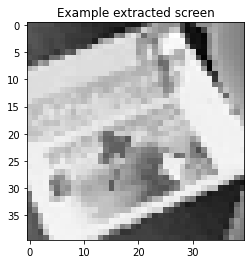

In [22]:
preprocess = T.Compose([T.ToPILImage(),
                    T.Grayscale(num_output_channels=1),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    global stacked_screens
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env._get_observation().transpose((2, 0, 1))
    # Convert to float, rescale, convert to torch tensor
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension 
    return preprocess(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0)[-1].numpy(),cmap='Greys',
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [23]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 200
EPS_DECAY_LAST_FRAME = 10**4
TARGET_UPDATE = 1000
LEARNING_RATE = 1e-4

# Get screen size so that we can initialize layers correctly based on shape
# returned from pybullet (48, 48, 3).  
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(10000)


eps_threshold = 0

def select_action(state, i_episode):
    global steps_done
    global eps_threshold
    sample = random.random()
    eps_threshold = max(EPS_END, EPS_START - i_episode / EPS_DECAY_LAST_FRAME)
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [24]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [25]:
PATH = 'policy_dqn.pt'

In [26]:
num_episodes = 10000
writer = SummaryWriter()
total_rewards = []
ten_rewards = 0
best_mean_reward = None
start_time = timeit.default_timer()
success_rate_history = []
# Add this line before the training loop
episode_rewards = []
success_rates = []  # Add this line before the training loop
n = 100  # Choose a value for n
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    state = get_screen()
    stacked_states = collections.deque(STACK_SIZE*[state],maxlen=STACK_SIZE)
    for t in count():
        stacked_states_t =  torch.cat(tuple(stacked_states),dim=1)
        # Select and perform an action
        action = select_action(stacked_states_t, i_episode)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        next_state = get_screen()
        if not done:
            next_stacked_states = stacked_states
            next_stacked_states.append(next_state)
            next_stacked_states_t =  torch.cat(tuple(next_stacked_states),dim=1)
        else:
            next_stacked_states_t = None
            
        # Store the transition in memory
        memory.push(stacked_states_t, action, next_stacked_states_t, reward)

        # Move to the next state
        stacked_states = next_stacked_states
        
        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            reward = reward.cpu().numpy().item()
            ten_rewards += reward
            total_rewards.append(reward)
            mean_reward = np.mean(total_rewards[-100:])*100
            writer.add_scalar("epsilon", eps_threshold, i_episode)
            if (best_mean_reward is None or best_mean_reward < mean_reward) and i_episode > 100:
                # For saving the model and possibly resuming training
                torch.save({
                        'policy_net_state_dict': policy_net.state_dict(),
                        'target_net_state_dict': target_net.state_dict(),
                        'optimizer_policy_net_state_dict': optimizer.state_dict()
                        }, PATH)
                if best_mean_reward is not None:
                    print("Best mean reward updated %.1f -> %.1f, model saved" % (best_mean_reward, mean_reward))
                best_mean_reward = mean_reward
            episode_rewards.append(reward)
            break
            
    if i_episode%10 == 0:
            writer.add_scalar('ten episodes average rewards', ten_rewards/10.0, i_episode)
            ten_rewards = 0
# Add this code block inside your training loop
    if (i_episode + 1) % n == 0:
            successful_episodes = sum([1 for reward in total_rewards[-n:] if reward > 0])
            success_rate = (successful_episodes / n) * 100
            success_rates.append(success_rate)
            writer.add_scalar('success rate', success_rate, i_episode)        
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if i_episode>=200 and mean_reward>50:
        print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode+1, mean_reward))
        break


print('Average Score: {:.2f}'.format(mean_reward))
elapsed = timeit.default_timer() - start_time
print("Elapsed time: {}".format(timedelta(seconds=elapsed)))
writer.close()
env.close()

Best mean reward updated 28.0 -> 29.0, model saved
Best mean reward updated 29.0 -> 30.0, model saved
Best mean reward updated 30.0 -> 31.0, model saved
Best mean reward updated 31.0 -> 32.0, model saved
Best mean reward updated 32.0 -> 33.0, model saved
Best mean reward updated 33.0 -> 34.0, model saved
Best mean reward updated 34.0 -> 35.0, model saved
Best mean reward updated 35.0 -> 36.0, model saved
Best mean reward updated 36.0 -> 37.0, model saved
Best mean reward updated 37.0 -> 38.0, model saved
Best mean reward updated 38.0 -> 39.0, model saved
Best mean reward updated 39.0 -> 40.0, model saved
Best mean reward updated 40.0 -> 41.0, model saved
Best mean reward updated 41.0 -> 42.0, model saved
Best mean reward updated 42.0 -> 43.0, model saved
Best mean reward updated 43.0 -> 44.0, model saved
Best mean reward updated 44.0 -> 45.0, model saved
Best mean reward updated 45.0 -> 46.0, model saved
Best mean reward updated 46.0 -> 47.0, model saved
Best mean reward updated 47.0 -

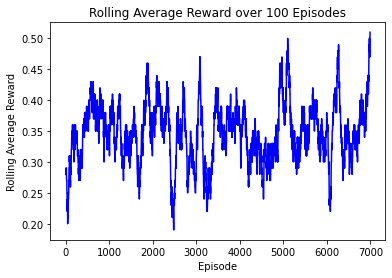

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the rolling average of rewards
rolling_avg_window = 100
rolling_avg_rewards = np.convolve(episode_rewards, np.ones(rolling_avg_window) / rolling_avg_window, mode='valid')

# Create a plot for the rolling average of rewards
episodes = list(range(1, len(episode_rewards) - rolling_avg_window + 2))
plt.plot(episodes, rolling_avg_rewards, color='blue')

# Add labels and title
plt.xlabel('Episode')
plt.ylabel('Rolling Average Reward')
plt.title('Rolling Average Reward over {} Episodes'.format(rolling_avg_window))

# Display the plot
plt.show()

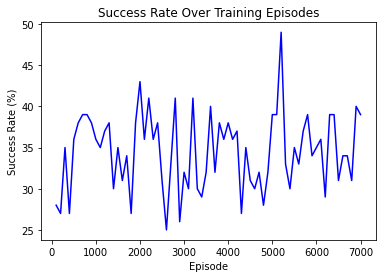

In [28]:
import matplotlib.pyplot as plt

# Create a line plot for the success rate
episode_windows = [n * (i + 1) for i in range(len(success_rates))]
plt.plot(episode_windows, success_rates, color='blue')

# Add labels and title
plt.xlabel('Episode')
plt.ylabel('Success Rate (%)')
plt.title('Success Rate Over Training Episodes')

# Display the plot
plt.show()

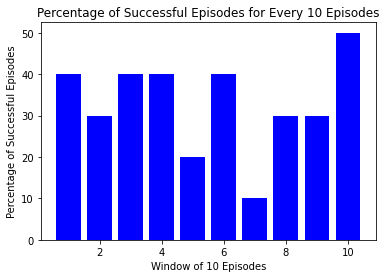

In [15]:
episode = 100
successful_episodes = 0
scores_window = collections.deque(maxlen=100)  # last 100 scores
env = KukaDiverseObjectEnv(renders=False, isDiscrete=True, removeHeightHack=False, maxSteps=20, isTest=True)
env.cid = p.connect(p.DIRECT)
# load the model
checkpoint = torch.load(PATH)
policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
evaluation_rewards = []
# evaluate the model
for i_episode in range(episode):
    env.reset()
    state = get_screen()
    stacked_states = collections.deque(STACK_SIZE*[state],maxlen=STACK_SIZE)
    for t in count():
        stacked_states_t =  torch.cat(tuple(stacked_states),dim=1)
        # Select and perform an action
        action = policy_net(stacked_states_t).max(1)[1].view(1, 1)
        _, reward, done, _ = env.step(action.item())
        # Observe new state
        next_state = get_screen()
        stacked_states.append(next_state)
        if done:
            evaluation_rewards.append(reward)
            if reward > 0:
                successful_episodes += 1
            break
    #print("Episode: {0:d}, reward: {1}".format(i_episode+1, reward), end="\n")

success_rate = successful_episodes / episode * 100
#print(f"Success rate for all {episode} episodes: {success_rate}%")

percentage_window = 10
successful_episodes_percentages = []

for i in range(0, len(evaluation_rewards), percentage_window):
    successful_episodes_in_window = sum([1 for reward in evaluation_rewards[i:i + percentage_window] if reward > 0])
    successful_percentage = (successful_episodes_in_window / percentage_window) * 100
    successful_episodes_percentages.append(successful_percentage)

import matplotlib.pyplot as plt

# Create a bar plot for the percentage of successful episodes
windows = list(range(1, len(successful_episodes_percentages) + 1))
plt.bar(windows, successful_episodes_percentages, color='blue')

# Add labels and title
plt.xlabel('Window of 10 Episodes')
plt.ylabel('Percentage of Successful Episodes')
plt.title('Percentage of Successful Episodes for Every 10 Episodes')

# Display the plot
plt.show()